## Import Modul

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import json
import os

In [2]:
def load_data():
    """
    Load preprocessed data from the output folder.

    Returns:
    tuple: X_train, X_test, y_train, y_test, and class weights.
    """
    output_dir = os.path.join(os.path.dirname(os.getcwd()), "Output")
    
    X_train = np.load(os.path.join(output_dir, "X_train.npy"))
    X_test = np.load(os.path.join(output_dir, "X_test.npy"))
    y_train = np.load(os.path.join(output_dir, "y_train.npy"))
    y_test = np.load(os.path.join(output_dir, "y_test.npy"))
    class_weight_dict = np.load(os.path.join(output_dir, "class_weights.npy"), allow_pickle=True).item()

    return X_train, X_test, y_train, y_test, class_weight_dict

In [3]:
# Load data

X_train, X_test, y_train, y_test, class_weight_dict = load_data()

In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1524, 180, 180, 2), (381, 180, 180, 2), (1524, 3), (381, 3))

In [5]:
X_train

array([[[[-7.9996948e+01, -5.7313220e+02],
         [-7.9995247e+01, -5.5195453e+02],
         [-8.0000000e+01, -5.6657074e+02],
         ...,
         [-8.0000000e+01, -6.2565338e+02],
         [-8.0000000e+01, -6.2565796e+02],
         [-8.0000000e+01, -6.2565796e+02]],

        [[-7.9998680e+01, -5.7313220e+02],
         [-7.9997940e+01, -5.5195453e+02],
         [-8.0000000e+01, -5.6657074e+02],
         ...,
         [-8.0000000e+01, -6.2565338e+02],
         [-8.0000000e+01, -6.2565796e+02],
         [-8.0000000e+01, -6.2565796e+02]],

        [[-8.0000000e+01, -5.7313220e+02],
         [-8.0000000e+01, -5.5195453e+02],
         [-8.0000000e+01, -5.6657074e+02],
         ...,
         [-8.0000000e+01, -6.2565338e+02],
         [-8.0000000e+01, -6.2565796e+02],
         [-8.0000000e+01, -6.2565796e+02]],

        ...,

        [[-8.0000000e+01, -1.5032070e+01],
         [-8.0000000e+01, -1.0937807e+01],
         [-8.0000000e+01,  1.2063111e+00],
         ...,
         [-8.0000000e

In [6]:
y_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [7]:
def build_model(input_shape, num_classes):
    """
    Build and compile the CNN model with L2 regularization and dropout.

    Parameters:
    input_shape (tuple): The input shape of the data.
    num_classes (int): The number of output classes.

    Returns:
    tf.keras.Model: The compiled CNN model.
    """
    model = tf.keras.models.Sequential([
        # First Convolution Block
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01), padding='same', input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),

        # Second Convolution Block
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01), padding='same'),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),

        # Third Convolution Block
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01), padding='same'),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),

        # Dropout Layer
        Dropout(0.3),

        # Fourth Convolution Block
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01), padding='same'),
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),

        # Fifth Convolution Block
        Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.01), padding='same'),
        Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),

        # Dropout Layer
        Dropout(0.3),

        # Fully Connected Block
        Flatten(),
        Dense(1200, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.45),

        # Output Layer
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [8]:
def train_model(X_train, y_train, X_test, y_test, class_weight_dict):
    """
    Train the CNN model with early stopping and class weights.

    Parameters:
    X_train (numpy array): The training data.
    y_train (numpy array): The training labels.
    X_test (numpy array): The testing data.
    y_test (numpy array): The testing labels.
    class_weight_dict (dict): A dictionary containing class weights.

    Returns:
    history (History): The history of training.
    model (tf.keras.Model): The trained model.
    """
    model = build_model(X_train.shape[1:], y_train.shape[1])

    # EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_data=(X_test, y_test),
        class_weight=class_weight_dict,
        callbacks=[early_stopping]  # Early stopping to avoid overfitting
    )

    return history, model

In [9]:
# Train the model
history, model = train_model(X_train, y_train, X_test, y_test, class_weight_dict)

C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.3839 - loss: 35.0283 - val_accuracy: 0.7139 - val_loss: 29.5592
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.6794 - loss: 28.1102 - val_accuracy: 0.7795 - val_loss: 24.0177
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.7739 - loss: 22.8983 - val_accuracy: 0.7638 - val_loss: 19.9864
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8140 - loss: 19.0224 - val_accuracy: 0.8084 - val_loss: 16.7419
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8198 - loss: 16.0903 - val_accuracy: 0.8215 - val_loss: 14.3289
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8316 - loss: 13.8173 - val_accuracy: 0.8609 - val_loss: 12.3900
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8712 - loss: 11.9625 - val_accuracy: 0.8714 - val_loss: 10.8365
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8580 - loss: 10.5146 - val_accuracy: 0.8

In [10]:
def save_model_and_history(model, history):
    """
    Save the trained model and the training history.

    Parameters:
    model (tf.keras.Model): The trained model.
    history (History): The history of training.
    """
    # Tentukan folder tujuan
    save_dir = os.path.join(os.path.dirname(os.getcwd()), "Output")

    # Pastikan folder tujuan ada
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Menyimpan model ke folder Output
    model_save_path = os.path.join(save_dir, "trained_model.keras")
    model.save(model_save_path)

    print(f"Model saved at: {model_save_path}")

    # Menyimpan training history ke folder Output
    history_save_path = os.path.join(save_dir, "training_history.json")
    with open(history_save_path, "w") as f:
        json.dump(history.history, f)
        
    print(f"Training history saved at: {history_save_path}")

In [11]:
# Save the model and history
save_model_and_history(model, history)

Model saved at: d:\Team-1---DL-2024---Klasifikasi-Suara-Nyamuk-Menggunakan-CNN\Output\trained_model.keras
Training history saved at: d:\Team-1---DL-2024---Klasifikasi-Suara-Nyamuk-Menggunakan-CNN\Output\training_history.json


In [13]:
history.history

{'accuracy': [0.4685039222240448,
  0.6712598204612732,
  0.7821522355079651,
  0.8090550899505615,
  0.8202099800109863,
  0.8392388224601746,
  0.8556430339813232,
  0.8700787425041199,
  0.8884514570236206,
  0.8838582634925842,
  0.883202075958252,
  0.8982939720153809,
  0.9179790019989014,
  0.9127296805381775,
  0.9114173054695129,
  0.9258530139923096,
  0.930446207523346,
  0.9356955289840698,
  0.9363517165184021,
  0.9573490619659424,
  0.9468504190444946,
  0.9534120559692383,
  0.9671915769577026,
  0.9639107584953308,
  0.9501312375068665,
  0.9566929340362549,
  0.9639107584953308,
  0.9671915769577026,
  0.9586614370346069,
  0.9685039520263672],
 'loss': [33.26224136352539,
  26.81460189819336,
  21.900381088256836,
  18.291196823120117,
  15.541406631469727,
  13.347283363342285,
  11.613259315490723,
  10.203707695007324,
  9.042139053344727,
  8.101533889770508,
  7.3205413818359375,
  6.6206889152526855,
  5.999809265136719,
  5.519119739532471,
  5.079619407653809

In [15]:
def plot_training_history(history):
    """
    Plot the training history for loss and accuracy.

    Parameters:
    history (History): The history of training.
    """
    # Plot Training and Validation Loss
    epochs = [i for i in range(1, len(history.history['loss']) + 1)]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history.history['loss'], label='Training Loss', color='red')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Training and Validation Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='green')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

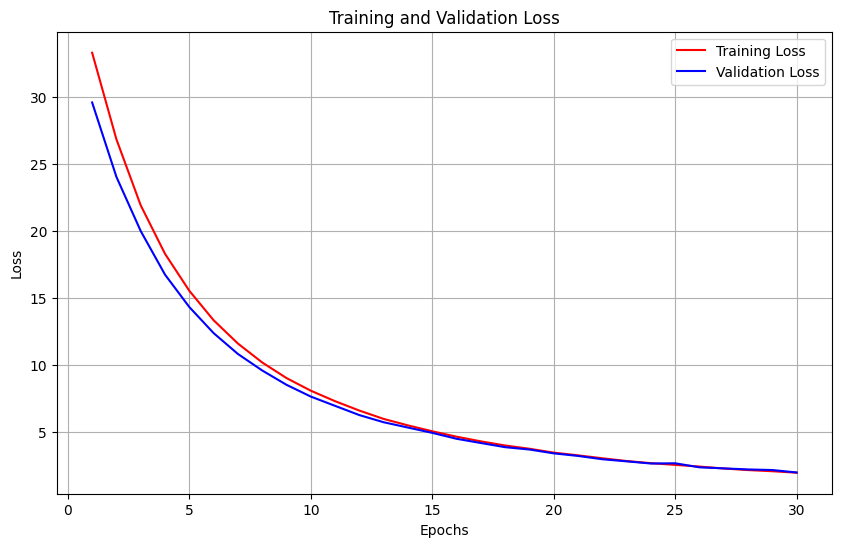

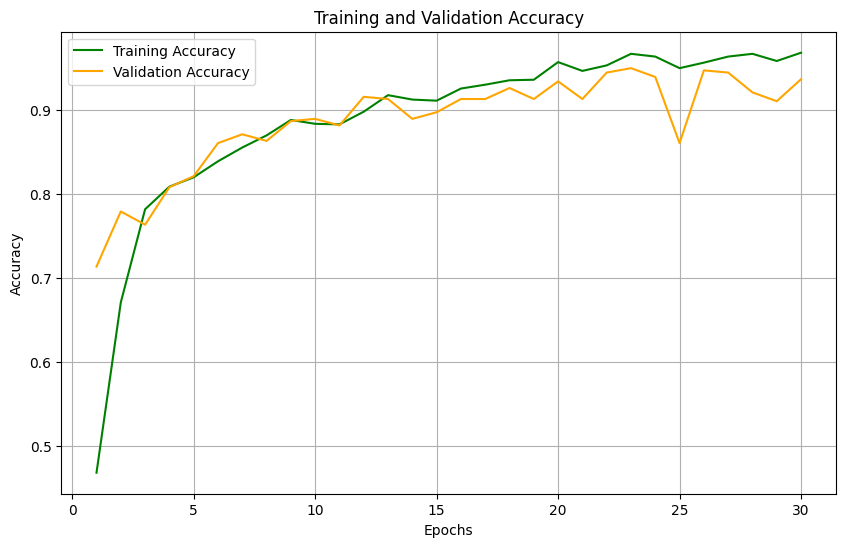

In [16]:
# Plot training history
plot_training_history(history)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, classes):
    """
    Evaluate the model's performance on the test set and print a classification report.

    Parameters:
    model (tf.keras.Model): The trained model.
    X_test (numpy array): The testing data.
    y_test (numpy array): The testing labels.
    classes (list): The list of class names.
    """
    y_pred = model.predict(X_test)
    predicted_categories = np.argmax(y_pred, axis=1)
    true_categories = np.argmax(y_test, axis=1)

    # Print classification report
    print(classification_report(true_categories, predicted_categories, target_names=classes))

    # Confusion Matrix
    cm = confusion_matrix(true_categories, predicted_categories)

    # Visualize Confusion Matrix
    import seaborn as sns
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for Mosquito Classification')
    plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 444ms/step
                     precision    recall  f1-score   support

      Aedes Aegypti       1.00      0.92      0.96       132
Anopheles Stephensi       0.97      0.90      0.94       122
      Culex Pipiens       0.86      0.98      0.92       127

           accuracy                           0.94       381
          macro avg       0.94      0.94      0.94       381
       weighted avg       0.94      0.94      0.94       381



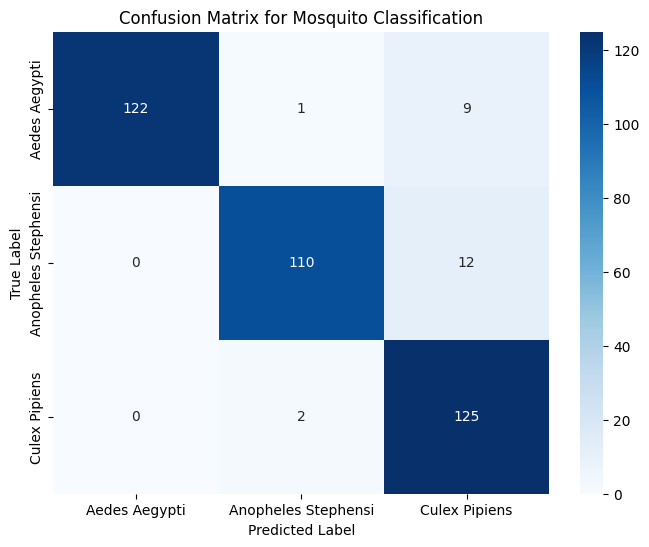

In [18]:
# Evaluate model performance

classes = ["Aedes Aegypti", "Anopheles Stephensi", "Culex Pipiens"]
evaluate_model(model, X_test, y_test, classes)